# Sonar - Mines vs. Rocks

The task is to discriminate between sonar signals bounced off a metal cylinder and those bounced off a roughly cylindrical rock. Or simply predict metal or rock objects from sonar return data.

This notebook is mainly for demonstrating Weights and Biases integration.

## Dataset Description

The file "sonar.mines" contains 111 patterns obtained by bouncing sonar signals off a metal cylinder at various angles and under various conditions. The file "sonar.rocks" contains 97 patterns obtained from rocks under similar conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. The data set contains signals obtained from a variety of different aspect angles, spanning 90 degrees for the cylinder and 180 degrees for the rock.

Each pattern is a set of 60 numbers in the range 0.0 to 1.0.  Each number represents the energy within a particular frequency band, integrated over a certain period of time.  The integration aperture for higher frequencies occur later in time, since these frequencies are transmitted later during the chirp.

The label associated with each record contains the letter "R" if the object is a rock and "M" if it is a mine (metal cylinder).  The numbers in the labels are in increasing order of aspect angle, but they do not encode the angle directly.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from pickle import dump
from pickle import load

import wandb

%matplotlib inline

In [2]:
!wandb login

wandb: Appending key for 10.1.56.105 to your netrc file: /home/sheffield/.netrc


In [3]:
wandb.init(project="sonar-mines-vs-rocks", name='classification')

wandb: Currently logged in as: bsheffield. Use `wandb login --relogin` to force relogin


In [5]:
# Load dataset
filename = 'sonar.all-data'
df = pd.read_csv(filename, header=None)

In [6]:
#df.head(20)
df.sample(10)

0       1       2       3       4       5       6       7       8   \
184  0.0269  0.0383  0.0505  0.0707  0.1313  0.2103  0.2263  0.2524  0.3595   
15   0.0298  0.0615  0.0650  0.0921  0.1615  0.2294  0.2176  0.2033  0.1459   
117  0.0228  0.0106  0.0130  0.0842  0.1117  0.1506  0.1776  0.0997  0.1428   
104  0.0307  0.0523  0.0653  0.0521  0.0611  0.0577  0.0665  0.0664  0.1460   
156  0.0047  0.0059  0.0080  0.0554  0.0883  0.1278  0.1674  0.1373  0.2922   
0    0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
40   0.0068  0.0232  0.0513  0.0444  0.0249  0.0637  0.0422  0.1130  0.1911   
188  0.0089  0.0274  0.0248  0.0237  0.0224  0.0845  0.1488  0.1224  0.1569   
155  0.0211  0.0128  0.0015  0.0450  0.0711  0.1563  0.1518  0.1206  0.1666   
83   0.0217  0.0340  0.0392  0.0236  0.1081  0.1164  0.1398  0.1009  0.1147   

         9   ...      51      52      53      54      55      56      57  \
184  0.5915  ...  0.0167  0.0199  0.0145  0.0081  0.0045  0.0043  0.0027   
15   0.0852  ...  0.0031  0.0153  0.0071  0.0212  0.0076  0.0152  0.0049   
117  0.2227  ...  0.0098  0.0178  0.0077  0.0074  0.0095  0.0055  0.0045   
104  0.2792  ...  0.0321  0.0189  0.0137  0.0277  0.0152  0.0052  0.0121   
156  0.3469  ...  0.0095  0.0126  0.0069  0.0039  0.0068  0.0060  0.0045   
0    0.2111  ...  0.0027  0.0065  0.0159  0.0072  0.0167  0.0180  0.0084   
40   0.2475  ...  0.0173  0.0163  0.0055  0.0045  0.0068  0.0041  0.0052   
188  0.2119  ...  0.0096  0.0103  0.0093  0.0025  0.0044  0.0021  0.0069   
155  0.1345  ...  0.0117  0.0023  0.0047  0.0049  0.0031  0.0024  0.0039   
83   0.1777  ...  0.0031  0.0103  0.0078  0.0077  0.0094  0.0031  0.0030   

         58      59  60  
184  0.0055  0.0057   M  
15   0.0200  0.0073   R  
117  0.0063  0.0039   M  
104  0.0124  0.0055   M  
156  0.0002  0.0029   M  
0    0.0090  0.0032   R  
40   0.0194  0.0105   R  
188  0.0060  0.0018   M  
155  0.0051  0.0015   M  
83   0.0013  0.0069   R  

[10 rows x 61 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       208 non-null    float64
 1   1       208 non-null    float64
 2   2       208 non-null    float64
 3   3       208 non-null    float64
 4   4       208 non-null    float64
 5   5       208 non-null    float64
 6   6       208 non-null    float64
 7   7       208 non-null    float64
 8   8       208 non-null    float64
 9   9       208 non-null    float64
 10  10      208 non-null    float64
 11  11      208 non-null    float64
 12  12      208 non-null    float64
 13  13      208 non-null    float64
 14  14      208 non-null    float64
 15  15      208 non-null    float64
 16  16      208 non-null    float64
 17  17      208 non-null    float64
 18  18      208 non-null    float64
 19  19      208 non-null    float64
 20  20      208 non-null    float64
 21  21      208 non-null    float64
 22  22

In [8]:
df.isnull().values.any()

False

In [9]:
df.describe().T

count      mean       std     min       25%      50%       75%     max
0   208.0  0.029164  0.022991  0.0015  0.013350  0.02280  0.035550  0.1371
1   208.0  0.038437  0.032960  0.0006  0.016450  0.03080  0.047950  0.2339
2   208.0  0.043832  0.038428  0.0015  0.018950  0.03430  0.057950  0.3059
3   208.0  0.053892  0.046528  0.0058  0.024375  0.04405  0.064500  0.4264
4   208.0  0.075202  0.055552  0.0067  0.038050  0.06250  0.100275  0.4010
5   208.0  0.104570  0.059105  0.0102  0.067025  0.09215  0.134125  0.3823
6   208.0  0.121747  0.061788  0.0033  0.080900  0.10695  0.154000  0.3729
7   208.0  0.134799  0.085152  0.0055  0.080425  0.11210  0.169600  0.4590
8   208.0  0.178003  0.118387  0.0075  0.097025  0.15225  0.233425  0.6828
9   208.0  0.208259  0.134416  0.0113  0.111275  0.18240  0.268700  0.7106
10  208.0  0.236013  0.132705  0.0289  0.129250  0.22480  0.301650  0.7342
11  208.0  0.250221  0.140072  0.0236  0.133475  0.24905  0.331250  0.7060
12  208.0  0.273305  0.140962  0.0184  0.166125  0.26395  0.351250  0.7131
13  208.0  0.296568  0.164474  0.0273  0.175175  0.28110  0.386175  0.9970
14  208.0  0.320201  0.205427  0.0031  0.164625  0.28170  0.452925  1.0000
15  208.0  0.378487  0.232650  0.0162  0.196300  0.30470  0.535725  0.9988
16  208.0  0.415983  0.263677  0.0349  0.205850  0.30840  0.659425  1.0000
17  208.0  0.452318  0.261529  0.0375  0.242075  0.36830  0.679050  1.0000
18  208.0  0.504812  0.257988  0.0494  0.299075  0.43495  0.731400  1.0000
19  208.0  0.563047  0.262653  0.0656  0.350625  0.54250  0.809325  1.0000
20  208.0  0.609060  0.257818  0.0512  0.399725  0.61770  0.816975  1.0000
21  208.0  0.624275  0.255883  0.0219  0.406925  0.66490  0.831975  1.0000
22  208.0  0.646975  0.250175  0.0563  0.450225  0.69970  0.848575  1.0000
23  208.0  0.672654  0.239116  0.0239  0.540725  0.69850  0.872175  1.0000
24  208.0  0.675424  0.244926  0.0240  0.525800  0.72110  0.873725  1.0000
25  208.0  0.699866  0.237228  0.0921  0.544175  0.75450  0.893800  1.0000
26  208.0  0.702155  0.245657  0.0481  0.531900  0.74560  0.917100  1.0000
27  208.0  0.694024  0.237189  0.0284  0.534775  0.73190  0.900275  1.0000
28  208.0  0.642074  0.240250  0.0144  0.463700  0.68080  0.852125  1.0000
29  208.0  0.580928  0.220749  0.0613  0.411400  0.60715  0.735175  1.0000
30  208.0  0.504475  0.213992  0.0482  0.345550  0.49035  0.641950  0.9657
31  208.0  0.439040  0.213237  0.0404  0.281400  0.42960  0.580300  0.9306
32  208.0  0.417220  0.206513  0.0477  0.257875  0.39120  0.556125  1.0000
33  208.0  0.403233  0.231242  0.0212  0.217575  0.35105  0.596125  0.9647
34  208.0  0.392571  0.259132  0.0223  0.179375  0.31275  0.593350  1.0000
35  208.0  0.384848  0.264121  0.0080  0.154350  0.32115  0.556525  1.0000
36  208.0  0.363807  0.239912  0.0351  0.160100  0.30630  0.518900  0.9497
37  208.0  0.339657  0.212973  0.0383  0.174275  0.31270  0.440550  1.0000
38  208.0  0.325800  0.199075  0.0371  0.173975  0.28350  0.434900  0.9857
39  208.0  0.311207  0.178662  0.0117  0.186450  0.27805  0.424350  0.9297
40  208.0  0.289252  0.171111  0.0360  0.163100  0.25950  0.387525  0.8995
41  208.0  0.278293  0.168728  0.0056  0.158900  0.24510  0.384250  0.8246
42  208.0  0.246542  0.138993  0.0000  0.155200  0.22255  0.324525  0.7733
43  208.0  0.214075  0.133291  0.0000  0.126875  0.17770  0.271750  0.7762
44  208.0  0.197232  0.151628  0.0000  0.094475  0.14800  0.231550  0.7034
45  208.0  0.160631  0.133938  0.0000  0.068550  0.12135  0.200375  0.7292
46  208.0  0.122453  0.086953  0.0000  0.064250  0.10165  0.154425  0.5522
47  208.0  0.091424  0.062417  0.0000  0.045125  0.07810  0.120100  0.3339
48  208.0  0.051929  0.035954  0.0000  0.026350  0.04470  0.068525  0.1981
49  208.0  0.020424  0.013665  0.0000  0.011550  0.01790  0.025275  0.0825
50  208.0  0.016069  0.012008  0.0000  0.008425  0.01390  0.020825  0.1004
51  208.0  0.013420  0.009634  0.0008  0.007275  0.01140  0.016725  0.0709
52  208.0  0.010709  0.007060

In [10]:
df.groupby(60).size()

60
M    111
R     97
dtype: int64

In [11]:
df[60].replace('M', 1, inplace=True)
df[60].replace('R', 0, inplace=True)

In [12]:
df.sample(10)

0       1       2       3       4       5       6       7       8   \
33   0.0442  0.0477  0.0049  0.0581  0.0278  0.0678  0.1664  0.1490  0.0974   
77   0.0336  0.0294  0.0476  0.0539  0.0794  0.0804  0.1136  0.1228  0.1235   
106  0.0331  0.0423  0.0474  0.0818  0.0835  0.0756  0.0374  0.0961  0.0548   
204  0.0323  0.0101  0.0298  0.0564  0.0760  0.0958  0.0990  0.1018  0.1030   
6    0.0317  0.0956  0.1321  0.1408  0.1674  0.1710  0.0731  0.1401  0.2083   
87   0.0856  0.0454  0.0382  0.0203  0.0385  0.0534  0.2140  0.3110  0.2837   
69   0.0216  0.0215  0.0273  0.0139  0.0357  0.0785  0.0906  0.0908  0.1151   
198  0.0238  0.0318  0.0422  0.0399  0.0788  0.0766  0.0881  0.1143  0.1594   
152  0.0131  0.0201  0.0045  0.0217  0.0230  0.0481  0.0742  0.0333  0.1369   
43   0.0093  0.0269  0.0217  0.0339  0.0305  0.1172  0.1450  0.0638  0.0740   

         9   ...      51      52      53      54      55      56      57  \
33   0.1268  ...  0.0204  0.0216  0.0135  0.0055  0.0073  0.0080  0.0105   
77   0.0842  ...  0.0150  0.0111  0.0032  0.0035  0.0169  0.0137  0.0015   
106  0.0193  ...  0.0078  0.0174  0.0176  0.0038  0.0129  0.0066  0.0044   
204  0.2154  ...  0.0061  0.0093  0.0135  0.0063  0.0063  0.0034  0.0032   
6    0.3513  ...  0.0201  0.0248  0.0131  0.0070  0.0138  0.0092  0.0143   
87   0.2751  ...  0.0172  0.0138  0.0079  0.0037  0.0051  0.0258  0.0102   
69   0.0973  ...  0.0140  0.0044  0.0052  0.0073  0.0021  0.0047  0.0024   
198  0.2048  ...  0.0096  0.0071  0.0084  0.0038  0.0026  0.0028  0.0013   
152  0.2079  ...  0.0168  0.0086  0.0045  0.0062  0.0065  0.0030  0.0066   
43   0.1360  ...  0.0212  0.0091  0.0056  0.0086  0.0092  0.0070  0.0116   

         58      59  60  
33   0.0059  0.0105   0  
77   0.0069  0.0051   0  
106  0.0134  0.0092   1  
204  0.0062  0.0067   1  
6    0.0036  0.0103   0  
87   0.0037  0.0037   0  
69   0.0009  0.0017   0  
198  0.0035  0.0060   1  
152  0.0029  0.0053   1  
43   0.0060  0.0110   0  

[10 rows x 61 columns]

# Dataset Visualization

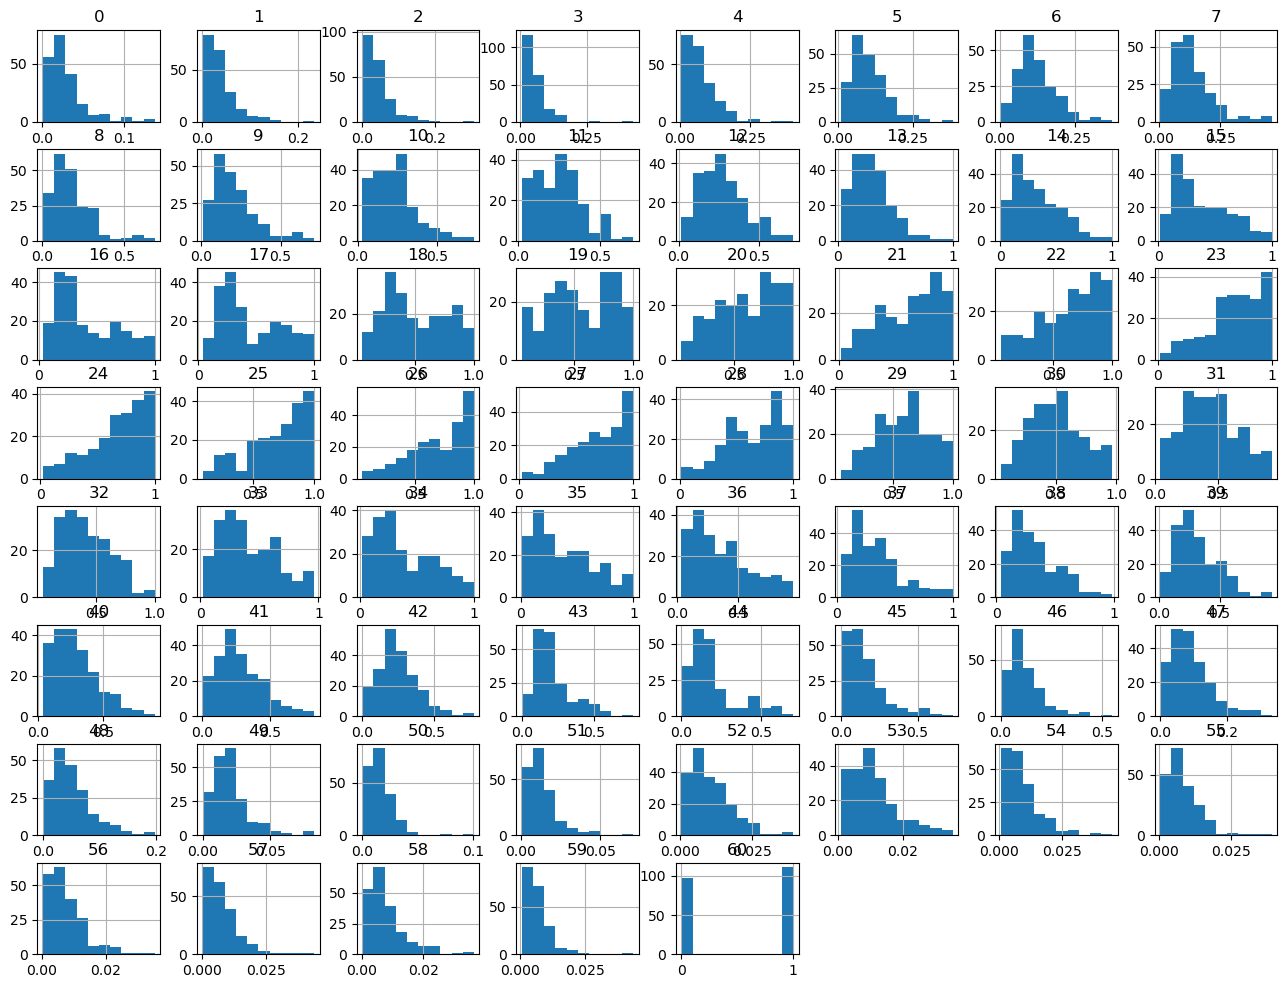

In [13]:
df.hist(figsize=(16,12));

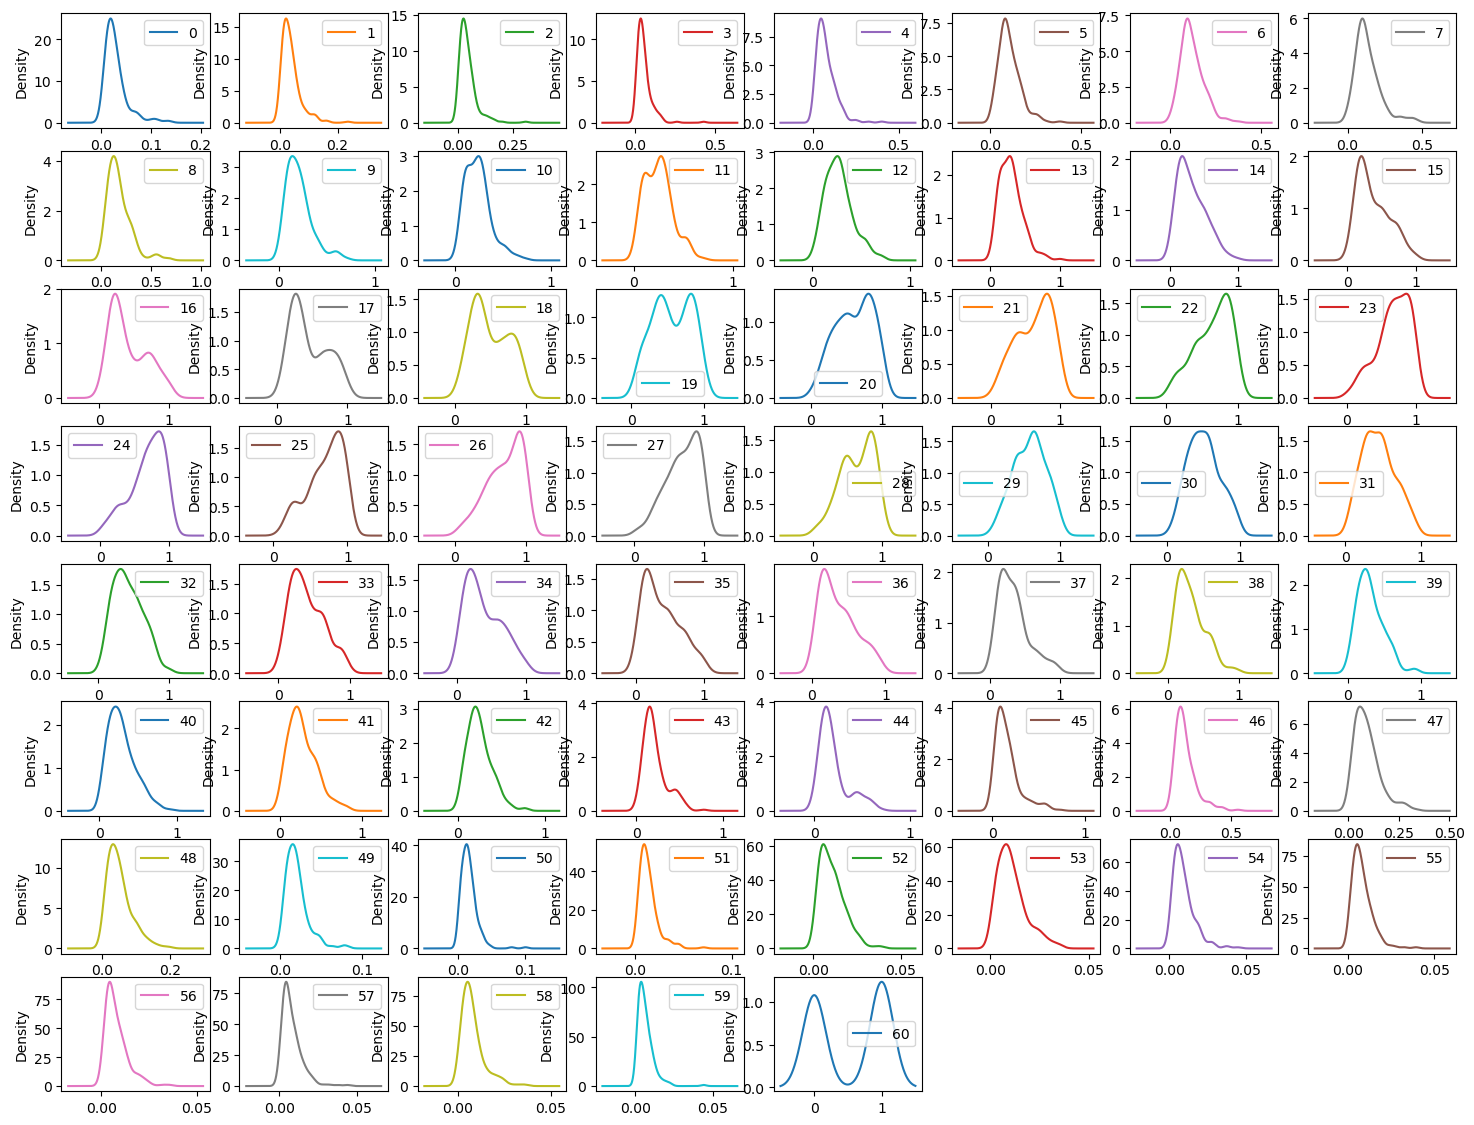

In [14]:
df.plot(kind='density', subplots=True, layout=(8,8), sharex=False, figsize=(18, 14));

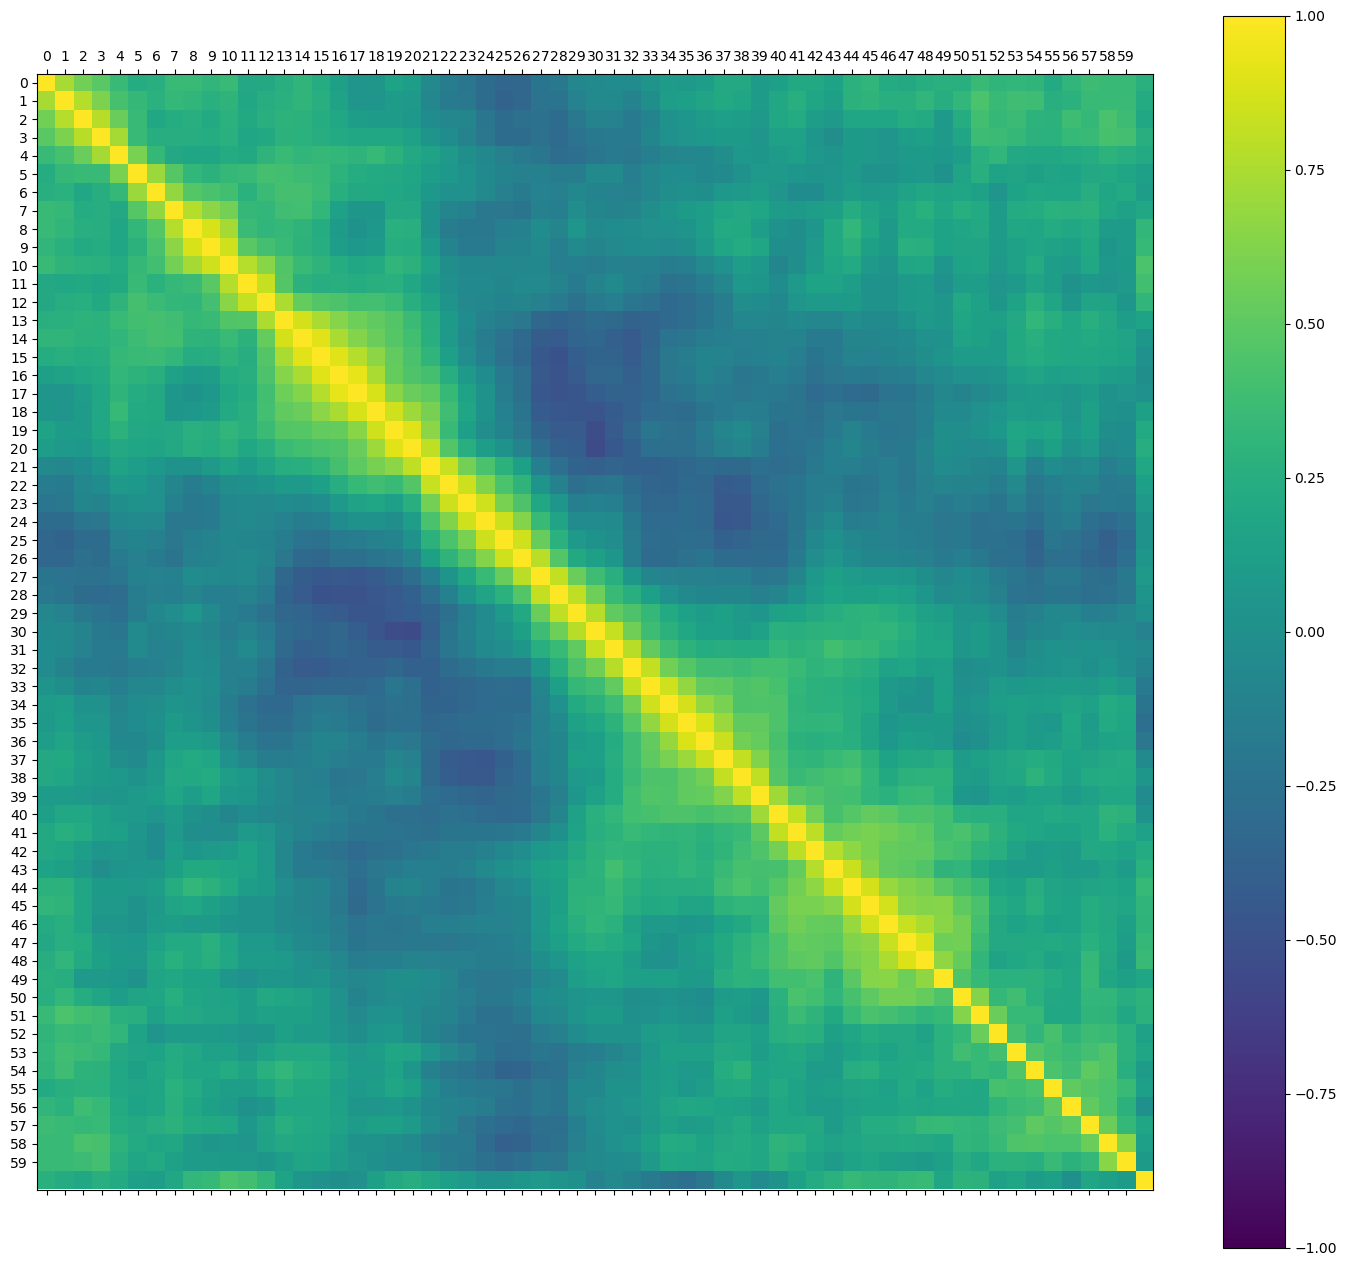

In [15]:
correlations = df.corr()

# Plot correlation matrix
fig = plt.figure(figsize=(18,16))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = np.arange(0, 60, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.show()

* The yellow/light green around the diagonal suggests that attributes that are next to each other are generally more correlated with each other. 

* The blue patches also suggest some moderate negative correlation the further attributes are away from each other in the ordering. This makes sense if the order of the attributes refers to the angle of sensors for the sonar chirp.

# Test dataset

In [16]:
arr = df.values
X = arr[:,0:60]
y = arr[:,60]

labels=['M','R']

test_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [17]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
Y_probas = model.predict_proba(X_test)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

In [18]:
wandb.sklearn.plot_class_proportions(Y_train, Y_test, labels)

In [19]:
wandb.sklearn.plot_precision_recall(Y_test, Y_probas, labels)

wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


In [20]:
wandb.sklearn.plot_summary_metrics(model, X_train, Y_train, X_test, Y_test)

In [21]:
wandb.sklearn.plot_learning_curve(model, X_train, Y_train)

In [22]:
wandb.sklearn.plot_confusion_matrix(Y_test, Y_pred, labels)

In [23]:
wandb.sklearn.plot_calibration_curve(model, X_train, Y_train, 'RandomForestClassifier')

In [24]:
wandb.sklearn.plot_classifier(model, X_train, X_test, Y_train, Y_test, Y_pred, Y_probas, labels, model_name="RandomForestClassifier", feature_names=None)

wandb: 
wandb: Plotting RandomForestClassifier.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [25]:
wandb.sklearn.plot_roc(Y_pred, Y_probas, labels)

In [26]:
filename = 'model.sav' 
dump(model, open(filename, 'wb'))

wandb.log_artifact(filename, name='model_artifact', type='my_model') 

In [27]:
artifact = wandb.use_artifact('bsheffield/sonar-mines-vs-rocks/model_artifact:v0', type='my_model')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  
